## Kaggle Climate Change Belief Challenge

Alta Saunders

# Aim

Develop a machine leraning model that can predict whether people belief in Climate Change based on tweets.

# Supplied Data sets

- train.csv (should be used to train data)
- test.csv (should be used to test data and excludes arrival times)
- example of submission

# Import and viewing of Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df_train = pd.read_csv('C:/Users/alta/Documents/GitHub/kaggle/train.csv')
df_test = pd.read_csv('C:/Users/alta/Documents/GitHub/kaggle/test.csv')
df_sub = pd.read_csv('C:/Users/alta/Documents/GitHub/kaggle/sample_submission.csv')

In [3]:
df_train.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


In [4]:
import nltk 
nltk.download('words')
words = set(nltk.corpus.words.words())


[nltk_data] Downloading package words to
[nltk_data]     C:\Users\alta\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


# Preprocessing of data

In [5]:
import re

View data to see how to best clean it and remove noise

To clean data we can remove the @.... strings, we can remove punctuation and make everything lower case.

In [6]:
pattern_tweets = r'(RT)|(@[A-Za-z0-9]+)'
pattern_url = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'



In [7]:
tweets = df_train['message']

In [8]:
tweets_clean = []

from string import punctuation
my_punctuation = punctuation.replace("'", "")

for x in tweets:
    new = ' '.join(re.sub(pattern_tweets," ",x).split())
    new1 = ' '.join(re.sub(pattern_url," ",new).split())
    new2 = new1.translate(str.maketrans("", "", my_punctuation))
    new3 = ' '.join(re.sub(r'[^a-zA-Z]', " ",new2).split())
   
    tweets_clean.append(new3)

There are non-english tweets in the training dataset, however there are very few non-english tweets in the test dataset. We do not want to train our model on non-englisg tokens> Lets remove all non-englisjh characters.

In [9]:
len(tweets_clean)

15819

In [10]:
df_train['message'] = tweets_clean

In [11]:
#make lower case
df_train['message'] = df_train['message'].str.lower()

In [12]:
df_clean = df_train

## Dealing with Imbalanced data

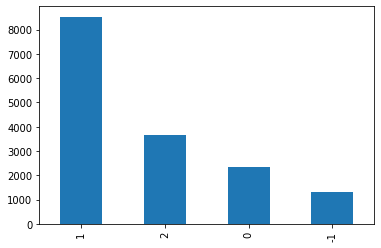

In [13]:
df_clean['sentiment'].value_counts().plot(kind = 'bar')
plt.show()

There is a clear disparity in the distribution of the data (2,0,-1 are under represented). Everything needs to be equal before training.

In [14]:
# Indicies of each group
sentiment_0 = df_clean[df_clean.sentiment == 0]
sentiment_1 = df_clean[df_clean.sentiment == 1]
sentiment_2 = df_clean[df_clean.sentiment == 2]
sentiment_n1 = df_clean[df_clean.sentiment == -1]

In [15]:
# get length of majority sentiment
n_sentiment2 = len(sentiment_2)

In [16]:
from sklearn.utils import resample

In [17]:
# downsample majorityclass
sentiment_0_upsampled = resample(sentiment_0, replace=True, n_samples=n_sentiment2, random_state=50) 
sentiment_1_upsampled = resample(sentiment_1, replace=True, n_samples=n_sentiment2, random_state=50)
sentiment_n1_upsampled = resample(sentiment_n1, replace=True, n_samples=n_sentiment2, random_state=50)
 

In [18]:
#create new upsampled dataframe
df_upsampled = pd.concat([sentiment_0_upsampled, sentiment_1_upsampled,sentiment_n1_upsampled, sentiment_2])

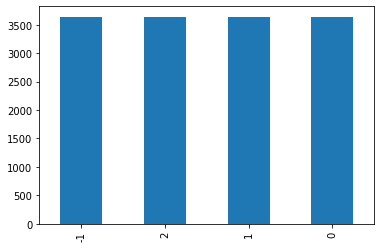

In [19]:
df_upsampled['sentiment'].value_counts().plot(kind = 'bar')
plt.show()

## Tokenization

In [20]:
from nltk.tokenize import word_tokenize, TreebankWordTokenizer

In [21]:
tokeniser = TreebankWordTokenizer()
df_upsampled['tokens'] = df_upsampled['message'].apply(tokeniser.tokenize)

In [22]:
df_upsampled['tokens'].head()

11385    [we, re, talking, about, this, story, on, soci...
10030    [yes, and, the, view, will, find, a, way, to, ...
12929    [bogar, the, celebrities, who, are, all, screa...
14408    [how, can, people, still, try, to, deny, globa...
13470    [kong, is, there, really, a, god, does, global...
Name: tokens, dtype: object

# Lemmatization

In [23]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\alta\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [24]:
def lemma(words, lemmatizer):
    return [lemmatizer.lemmatize(word) for word in words]  

In [25]:
df_upsampled['lemma'] = df_upsampled['tokens'].apply(lemma, args=(lemmatizer, ))

## Vectorize

In [26]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

Concatenate the tokens that have been broken into a lemma

In [46]:
lemma_concat = []

for x in df_upsampled['lemma']:
    lemma_concat.append(' '.join(x))

In [47]:
df_upsampled['lemma_concat'] = lemma_concat

In [48]:
vect = TfidfVectorizer(stop_words = 'english', ngram_range=(1,3), max_features=5000)

In [49]:
X_tokens = vect.fit_transform(df_upsampled['lemma_concat'])
df_tokens = pd.DataFrame(X_tokens.A, columns=vect.get_feature_names())

In [50]:
df_tokens.head()

,abandoning,abandoning climate,abandoning climate change,abc,abortion,abou,abt,accelerating,accept,accord,...,young,young people,youth,youtube,yr,zero,zimmer,zimmer iceberg,zimmer iceberg global,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [51]:
df_tokens.to_csv(r'C:/Users/alta/Documents/Explore/Trains/Sprint 6/kaggle/df_tokenstfidf.csv', index = False)

In [52]:
#add sentiment and to dataframe
y = df_upsampled['sentiment']

# Train model

## Split data into train and test data set

In [53]:
df_tokens = pd.read_csv(r'C:/Users/alta/Documents/Explore/Trains/Sprint 6/kaggle/df_tokenstfidf.csv')

In [54]:
df_tokens.shape

(14560, 5000)

In [55]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_tokens,y,test_size = 0.3, stratify = y, random_state = 11)

# Feature Selection

## Threshold variance

In [56]:
# Import the var thresh model and choose a threshold
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold()

# Transform (i.e.: run selection on) the training data
X_train_vt = selector.fit_transform(X_train)

In [ ]:
X_test_vt = selector.transform(X_test)

In [ ]:
X_train_vt.shape

In [ ]:
X_test_vt.shape

## K-best

In [ ]:
# Import the feature selector module
from sklearn import feature_selection
from sklearn.feature_selection import f_classif

# Set up selector, choosing score function and number of features to retain
selector_kbest = feature_selection.SelectKBest(score_func=f_classif, k=20)

# Transform (i.e.: run selection on) the training data
X_train_kbest = selector_kbest.fit_transform(X_train, y_train)

In [ ]:
# Before generating predictions, we'll need to transform the test data the same way we did the train data
X_test_kbest = selector_kbest.transform(X_test)

In [ ]:
X_test_kbest.shape

In [ ]:
X_train_kbest.shape

## Train model

In [57]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

In [58]:
#create models

#lr = LogisticRegression(C=0.05, penalty='l1', solver='liblinear', verbose=1) 
#kn = KNeighborsClassifier(5)
#svc_linear = SVC(kernel="linear", C=0.05)
svc = SVC(gamma=1, C=2)
#dtc = DecisionTreeClassifier(max_depth=10)
#rfc = RandomForestClassifier(max_depth=10, n_estimators=10)
#abc = AdaBoostClassifier()

In [59]:
#train model on train data
#lr.fit(X_train, y_train)
#kn.fit(X_train, y_train)
svc.fit(X_train, y_train)
#dtc.fit(X_train, y_train)
#rfc.fit(X_train, y_train)
#abc.fit(X_train, y_train)

SVC(C=2, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [60]:
#predict on test data
#lr_pred = lr.predict(X_test)
#kn_pred = kn.predict(X_test)
svc_pred =  svc.predict(X_test)
#dtc_pred = dtc.predict(X_test)
#rfc_pred = rfc.predict(X_test) 
#abc_pred = abc.predict(X_test)

create svc models with variance selecting

In [63]:
svc_kbest = SVC(gamma=1, C=2)
svc_kbest = svc_kbest.fit(X_train_kbest, y_train)
svc_kbest_pred = svc_kbest.predict(X_test_kbest)

In [64]:
svc_vt = SVC(gamma=1, C=2)
svc_vt = svc_vt.fit(X_train_vt, y_train)
svc_vt_pred = svc_vt.predict(X_test_vt)

## Calculate metrics

### F1

In [61]:
from sklearn import metrics

In [62]:
#lr_f1  = metrics.f1_score(y_test, lr_pred, average='macro')
#kn_f1  = metrics.f1_score(y_test, kn_pred, average='macro')
svc_f1  = metrics.f1_score(y_test, svc_pred, average='macro')
#dtc_f1  = metrics.f1_score(y_test, dtc_pred, average='macro')
#rfc_f1  = metrics.f1_score(y_test, rfc_pred, average='macro')
#abc_f1  = metrics.f1_score(y_test, abc_pred, average='macro')

In [63]:
#print('lr: ', lr_f1)
#print('kn: ', kn_f1)
print('svc: ', svc_f1)
#print('dtc: ', dtc_f1)
#print('rfc :', rfc_f1)
#print('abc :', abc_f1)

svc:  0.814467911313266


In [ ]:
svc_f1_vt  = metrics.f1_score(y_test, svc_vt_pred, average='macro')
svc_f1_kbest  = metrics.f1_score(y_test, svc_kbest_pred, average='macro')

In [69]:
print('vt: ', svc_f1_vt)
print('kbest: ', svc_f1_kbest)

vt:  0.6418356177500804
kbest:  0.43282546973485914


# Validate

In [65]:
from sklearn.model_selection import cross_val_score

In [66]:
print(cross_val_score(svc,X_test,y_test))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


[0.69230769 0.67445055 0.66346154]


## Tune Hyper parameters

In [179]:
from sklearn.model_selection import GridSearchCV

Since SVC model did the best, we will start with the hyper parameter tuning for it

In [180]:
nfolds = 2

Cs = [0.001, 0.01, 0.1, 1, 10]
gammas = [0.001, 0.01, 0.1, 1]

param_grid = {
    'C'     : Cs, 
    'gamma' : gammas
    }

grid_SVM = GridSearchCV(SVC(), param_grid, scoring='f1_micro', cv=nfolds)

In [ ]:
grid_SVM.best_params_

Now lets use to new hyperparamers and see if there is an improvement

In [67]:
svc_new = SVC(gamma=2, C=1)

In [68]:
svc_new.fit(X_train, y_train)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=2, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [69]:
svc_new_pred =  svc_new.predict(X_test)

In [72]:
svc_f1_new  = metrics.f1_score(y_test, svc_new_pred, average='macro')
print('svc_new: ', svc_f1_new)

svc_new:  0.821326031351069


In [71]:
print(cross_val_score(svc_new,X_test,y_test))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


[0.68681319 0.65521978 0.66071429]


Save model to be used later

In [65]:
import pickle

In [66]:
model_saved_path = 'C:/Users/alta/Documents/Explore/Trains/Sprint 6/kaggle/svc.pkl'

In [67]:
with open(model_saved_path, 'wb') as file: pickle.dump(svc, file)

## Get submission dataframe

In [73]:
df_test = pd.read_csv('C:/Users/alta/Documents/GitHub/kaggle/test.csv')
df_sub = pd.read_csv('C:/Users/alta/Documents/GitHub/kaggle/sample_submission.csv')

In [74]:
df_test.head()

,message,tweetid
0,Europe will now be looking to China to make su...,169760
1,Combine this with the polling of staffers re c...,35326
2,"The scary, unimpeachable evidence that climate...",224985
3,@Karoli @morgfair @OsborneInk @dailykos \nPuti...,476263
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928


In [75]:
tweets_test = df_test['message']

tweets_test_clean = []

from string import punctuation
my_punctuation = punctuation.replace("'", "")

for x in tweets_test:
    new = ' '.join(re.sub(pattern_tweets," ",x).split())
    new1 = ' '.join(re.sub(pattern_url," ",new).split())
    new2 = new1.translate(str.maketrans("", "", my_punctuation))
    new3 = ' '.join(re.sub(r'[^a-zA-Z]', " ",new2).split())
   
    tweets_test_clean.append(new3)
    
    
df_test['message'] = tweets_test_clean

#make lower case
df_test['message'] = df_test['message'].str.lower()

In [76]:
df_test_clean = df_test

In [77]:
tokeniser = TreebankWordTokenizer()
df_test_clean['tokens'] = df_test_clean['message'].apply(tokeniser.tokenize)

df_test_clean['tokens'].head()

0    [europe, will, now, be, looking, to, china, to...
1    [combine, this, with, the, polling, of, staffe...
2    [the, scary, unimpeachable, evidence, that, cl...
3    [putin, got, to, you, too, jill, trump, doesn,...
4    [female, orgasms, cause, global, warming, sarc...
Name: tokens, dtype: object

In [78]:
lemmatizer = WordNetLemmatizer()

def lemma(words, lemmatizer):
    return [lemmatizer.lemmatize(word) for word in words]  

df_test_clean['lemma'] = df_test_clean['tokens'].apply(lemma, args=(lemmatizer, ))

In [79]:
lemma_concat_test = []

for x in df_test_clean['lemma']:
    lemma_concat_test.append(' '.join(x))

df_test_clean['lemma_concat'] = lemma_concat_test

In [80]:
X_test_tokens = vect.transform(df_test_clean['lemma_concat'])
df_test_tokens = pd.DataFrame(X_test_tokens.A, columns=vect.get_feature_names())

In [81]:
y_test = svc_new.predict(df_test_tokens)

In [82]:
svc_final_df = pd.DataFrame()

svc_final_df['tweetid'] = df_test['tweetid']
svc_final_df['sentiment'] = y_test

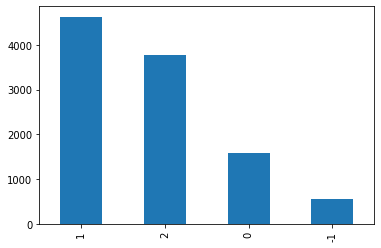

In [83]:
svc_final_df['sentiment'].value_counts().plot(kind = 'bar')
plt.show()

In [84]:
svc_final_df.to_csv(r'C:/Users/alta/Documents/Explore/Trains/Sprint 6/kaggle/svc_new_kaggle_sumbmission.csv', index = False)